In [183]:
!jupyter nbconvert fourier_transform.ipynb --to python --no-prompt

[NbConvertApp] Converting notebook fourier_transform.ipynb to python
[NbConvertApp] Writing 3944 bytes to fourier_transform.py


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# DFT as basis change (i.e. C^N ~ C^N)
def dft(f):
    N,  = f.shape
    index = np.arange(N)
    nn, kk = np.meshgrid(index, index)
    A = np.exp(- 1j * kk / N * 2 * np.pi * nn)
    g = A @ f
    return g

def idft(g):
    N,  = g.shape
    index = np.arange(N)
    kk, nn = np.meshgrid(index, index)
    A = np.exp(1j * nn / N * 2 * np.pi * kk)
    f = A @ g / N
    return f

def test_0():
    f = np.random.randn(2**8)
    assert np.allclose(idft(dft(f)), f)

test_0()

In [32]:
# NOTE: 2**6 * 2**(2*12) = 1GiB
for n in range(12):
    print(f":: n = {n}")
    _ = np.random.randn(2**n)
    %timeit -r3 dft(_)
    print()

:: n = 0
33.8 µs ± 102 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)

:: n = 1
55.8 µs ± 172 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)

:: n = 2
57.3 µs ± 361 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)

:: n = 3
61.1 µs ± 568 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)

:: n = 4
80.9 µs ± 824 ns per loop (mean ± std. dev. of 3 runs, 10000 loops each)

:: n = 5
134 µs ± 2.96 µs per loop (mean ± std. dev. of 3 runs, 10000 loops each)

:: n = 6
540 µs ± 18 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)

:: n = 7
1.81 ms ± 2.6 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)

:: n = 8
7.72 ms ± 111 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)

:: n = 9
29.6 ms ± 2.2 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)

:: n = 10
117 ms ± 298 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)

:: n = 11
332 ms ± 3.52 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)



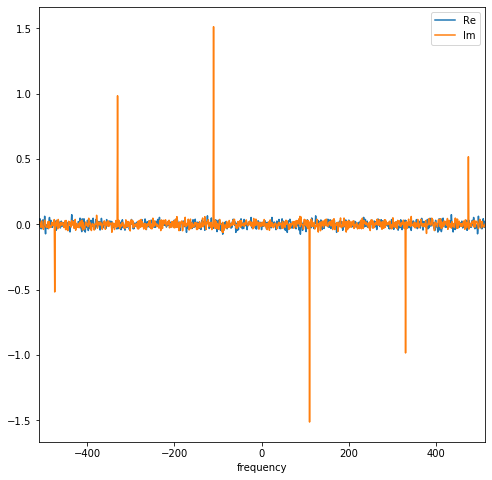

In [193]:
# DFT as Riemann-sum approx. of Fourier series (L^2([-A, A]) ~ l^2(Z))

def make_sample():
    # major code via harmonics (A, E, C#)
    freqs = [110, 110 * 3, 110 * 5] 
    amps = [3, 2, 1]
    duration = 1
    sample_rate = 2**10
    x = np.linspace(0, duration, duration * sample_rate, endpoint=False)
    y = sum([ a * np.sin(2 * np.pi * f * x) for f, a in zip(freqs, amps) ])
    # Add noise
    y += np.random.normal(scale=1, size=x.shape)
    return y, sample_rate

def plot_fourier_series():
    y, sample_rate = make_sample()
    N, = y.shape
    a = 1 / sample_rate # spacing of sample (just it was easier to analyze with this)
    y_ = dft(y)

    # Handle positive/negative parts of frequency 
    if N % 2 == 1:
        K = int((N - 1) / 2)
        freqs = np.arange(-K, K+1)
        amp = np.concatenate([y_[K+1:], y_[:K+1]])
    else:
        K = int(N / 2)
        freqs = np.arange(-K+1, K+1)
        amp = np.concatenate([y_[K+1:], y_[:K+1]])


    # Scale by some factors so that thery are Riemann-sum.
    amp = np.sqrt(a / N) * amp
    freqs = freqs / (N * a)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    import pandas as pd
    df = pd.DataFrame({'frequency': freqs, 'Re': np.real(amp), 'Im': np.imag(amp)})
    df.plot.line(x='frequency', y=['Re', 'Im'], ax=ax)

plot_fourier_series()

In [159]:
# Fast fourier transform
def fft(f, leaf_size=5):
    N, = f.shape
    assert N == 2 ** (N.bit_length() - 1), 'N must be power of 2'
    assert N >= 2 ** leaf_size

    def dft_matrix(N):
        index = np.arange(N)
        nn, kk = np.meshgrid(index, index)
        A = np.exp(- 1j * kk / N * 2 * np.pi * nn)    
        return A    
    
    leaf_transform = dft_matrix(2**leaf_size)
    
    def _fft(f, g, N):
        if N == 2**leaf_size:
            np.matmul(leaf_transform, f, out=g)

        else:
            _N = N // 2
            f_even  = f[0::2]
            f_odd   = f[1::2]
            g1 = g[:_N]
            g2  = g[_N:]
            _fft(f_even, g1, _N)
            _fft(f_odd,  g2, _N)
            # TODO: these should be all inplace
            k = np.arange(_N)
            e = np.exp(- 1j * k / N * 2 * np.pi)
            _g1 = g1 + e * g2
            _g2 = g1 - e * g2
            np.copyto(g1, _g1)
            np.copyto(g2, _g2)    
    
    g = np.empty_like(f)
    _fft(f, g, N)
    return g

def test_1():
    for n in range(12):
        _ = np.random.randn(2**n) + 1j * np.random.randn(2**n)
        assert np.allclose(dft(_), fft(_, leaf_size=0))
        
test_1()

In [162]:
leaf_size = 3
for n in range(leaf_size, 12):
    print(f":: n = {n}")
    _ = np.random.randn(2**n) + 1j * np.random.randn(2**n)
    print(":: - dft")
    %timeit -n3 -r3 dft(_)
    print(":: - fft")    
    %timeit -n3 -r3 fft(_, leaf_size=leaf_size)
    print()

:: n = 3
:: - dft
136 µs ± 23 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
:: - fft
260 µs ± 156 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)

:: n = 4
:: - dft
219 µs ± 82 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
:: - fft
146 µs ± 68.1 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)

:: n = 5
:: - dft
207 µs ± 43.8 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
:: - fft
233 µs ± 90.2 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)

:: n = 6
:: - dft
556 µs ± 12 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
:: - fft
422 µs ± 11.3 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)

:: n = 7
:: - dft
1.87 ms ± 49 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
:: - fft
649 µs ± 17.6 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)

:: n = 8
:: - dft
7.02 ms ± 292 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
:: - fft
1.22 ms ± 25.3 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)

:: n = 9
::

In [167]:
for leaf_size in range(5, 11):
    n = 20
    print(f":: n = {n}, leaf_size = {leaf_size}")
    _ = np.random.randn(2**n) + 1j * np.random.randn(2**n)
    %timeit -n1 -r2 fft(_, leaf_size=leaf_size)
    print()

:: n = 20, leaf_size = 5
1.26 s ± 14.7 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)

:: n = 20, leaf_size = 6
1.51 s ± 9.45 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)

:: n = 20, leaf_size = 7
1.12 s ± 10.3 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)

:: n = 20, leaf_size = 8
942 ms ± 8.3 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)

:: n = 20, leaf_size = 9
1.02 s ± 5.34 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)

:: n = 20, leaf_size = 10
1.36 s ± 27.4 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)

